<a href="https://colab.research.google.com/github/Edith123321/formative2group4/blob/main/Renny_Group_4__EfficientNetB0_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative 2 Assignment
# DETECTION WITH EfficientNetB0 - Renny Pascal Ihirwe


Implemented a binary classification system to detect malaria-infected cells
using transfer learning with EfficientNetB0 architecture.






In [35]:
# Cell 1: Setup and Imports
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_recall_curve, f1_score
import requests
import pandas as pd

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

✓ All libraries imported successfully
TensorFlow version: 2.19.0


In [57]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
BASE_DIR = "Malaria_data"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 4

# Create main directory
os.makedirs(BASE_DIR, exist_ok=True)
print("✓ Project directories initialized")

✓ Project directories initialized


In [37]:
# Downloading Dataset
dataset_url = "https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip"
zip_path = os.path.join(Base_dir, "cell_images.zip")

expected_size = 353342171 # Approximate size of the zip file in bytes

if not os.path.exists(zip_path) or os.path.getsize(zip_path) != expected_size:
    print("Downloading the dataset...")
    if os.path.exists(zip_path):
      os.remove(zip_path) # Remove incomplete file
    urllib.request.urlretrieve(dataset_url, zip_path)
    print("Dataset downloaded successfully!")
else:
    print("Dataset already exists and is complete!")

Dataset downloaded successfully!


In [38]:
# Quick Fix: Remove corrupted file and re-download
import os
import zipfile

zip_path = os.path.join(Base_dir, "cell_images.zip")

# Remove the corrupted file
if os.path.exists(zip_path):
    print("Removing corrupted file...")
    os.remove(zip_path)
    print("✓ Removed")

# Re-download with better error handling
print("Re-downloading dataset...")
import requests

url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))

with open(zip_path, 'wb') as f:
    downloaded = 0
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
            downloaded += len(chunk)
            if total_size > 0:
                percent = (downloaded / total_size) * 100
                print(f"\rProgress: {percent:.1f}%", end='')

print("\n✓ Download complete!")

# Verify it's a valid zip
try:
    with zipfile.ZipFile(zip_path, 'r') as test_zip:
        print(f"✓ Valid zip file with {len(test_zip.namelist())} files")
except zipfile.BadZipFile:
    print("Still corrupted. Try downloading manually.")

Removing corrupted file...
✓ Removed
Re-downloading dataset...
Progress: 100.0%
✓ Download complete!
✓ Valid zip file with 27563 files


In [39]:
#Extracting the dataset

extract_dir = os.path.join(Base_dir, "cell_images")
if not os.path.exists(extract_dir):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(Base_dir)
  print("Dataset extracted successfully!")
else:
  print("Dataset already extracted!")

Dataset already extracted!


# Data Exploration


Dataset Statistics:
Parasitized images: 13779
Uninfected images: 13779
Total images: 27558


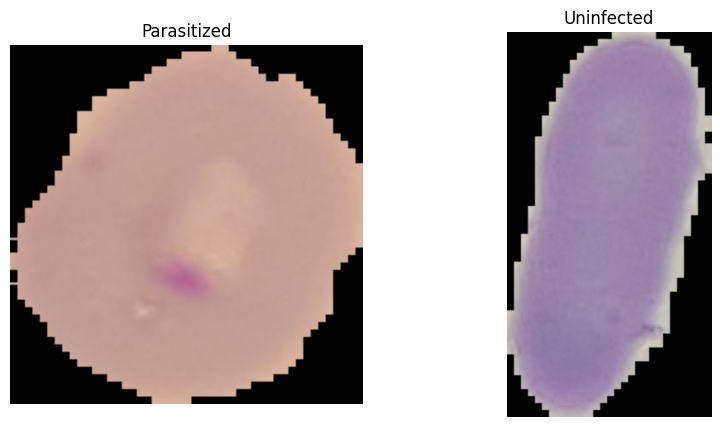

In [40]:
parasitized_dir = os.path.join(extract_dir, "Parasitized")
uninfected_dir = os.path.join(extract_dir, "Uninfected")

parasitized_images = [f for f in os.listdir(parasitized_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
uninfected_images = [f for f in os.listdir(uninfected_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print("Dataset Statistics:")
print(f"Parasitized images: {len(parasitized_images)}")
print(f"Uninfected images: {len(uninfected_images)}")
print(f"Total images: {len(parasitized_images) + len(uninfected_images)}")

# Visualize sample images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sample_para = np.random.choice(parasitized_images)
sample_uninf = np.random.choice(uninfected_images)

img_para = plt.imread(os.path.join(parasitized_dir, sample_para))
img_uninf = plt.imread(os.path.join(uninfected_dir, sample_uninf))

axes[0].imshow(img_para)
axes[0].set_title("Parasitized")
axes[0].axis('off')

axes[1].imshow(img_uninf)
axes[1].set_title("Uninfected")
axes[1].axis('off')
plt.show()

# Data Preparation Pipeline





In [52]:
def prepare_dataset_splits_fast():
    """Create train/val/test splits with SMALL subset for fast experimentation"""
    split_dirs = {
        "train": os.path.join(BASE_DIR, "train"),
        "val": os.path.join(BASE_DIR, "val"),
        "test": os.path.join(BASE_DIR, "test")
    }

    # Clean and create directories
    for split_dir in split_dirs.values():
        if os.path.exists(split_dir):
            shutil.rmtree(split_dir)
        os.makedirs(os.path.join(split_dir, "Parasitized"), exist_ok=True)
        os.makedirs(os.path.join(split_dir, "Uninfected"), exist_ok=True)

    def split_and_copy_fast(class_name, source_dir):
        images = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


        images = images[:300]
        # Split: 70% train, 15% val, 15% test
        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        # Copy to respective directories
        for split_name, img_list in [("train", train_imgs), ("val", val_imgs), ("test", test_imgs)]:
            dest_dir = os.path.join(split_dirs[split_name], class_name)
            for img_name in img_list:
                shutil.copy2(os.path.join(source_dir, img_name), os.path.join(dest_dir, img_name))

        return len(train_imgs), len(val_imgs), len(test_imgs)

    print("Creating FAST dataset splits (small subset)...")
    para_train, para_val, para_test = split_and_copy_fast("Parasitized", parasitized_dir)
    uninf_train, uninf_val, uninf_test = split_and_copy_fast("Uninfected", uninfected_dir)

    print("✓ FAST dataset splits created successfully")
    print(f"\n FAST Split Statistics (Small Subset):")
    print(f"Training:   {para_train + uninf_train:,} images (Parasitized: {para_train:,}, Uninfected: {uninf_train:,})")
    print(f"Validation: {para_val + uninf_val:,} images (Parasitized: {para_val:,}, Uninfected: {uninf_val:,})")
    print(f"Testing:    {para_test + uninf_test:,} images (Parasitized: {para_test:,}, Uninfected: {uninf_test:,})")
    print(" Using small subset for FAST experimentation")

    return split_dirs

#  USE THIS FAST VERSION INSTEAD
split_dirs = prepare_dataset_splits_fast()

Creating FAST dataset splits (small subset)...
✓ FAST dataset splits created successfully

 FAST Split Statistics (Small Subset):
Training:   420 images (Parasitized: 210, Uninfected: 210)
Validation: 90 images (Parasitized: 45, Uninfected: 45)
Testing:    90 images (Parasitized: 45, Uninfected: 45)
 Using small subset for FAST experimentation


In [54]:
#  Data Generators
def create_data_generators_fast():
    """Create data generators with small subset for fast training"""

    # Calculate class weights
    train_para_count = len(os.listdir(os.path.join(split_dirs["train"], "Parasitized")))
    train_uninf_count = len(os.listdir(os.path.join(split_dirs["train"], "Uninfected")))
    total_train = train_para_count + train_uninf_count

    class_weights = {
        0: total_train / (2 * train_uninf_count),  # Uninfected
        1: total_train / (2 * train_para_count)    # Parasitized
    }

    print(f"Class weights: {class_weights}")

    #  augmentation for faster processing
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  # Reduced from 20
        horizontal_flip=True,
        zoom_range=0.1      # Reduced from 0.2
    )

    # No augmentation for validation/test
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        split_dirs["train"],
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    val_generator = test_datagen.flow_from_directory(
        split_dirs["val"],
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        split_dirs["test"],
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    print(f"\n✓ FAST Data generators created")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Class indices: {train_generator.class_indices}")

    return train_generator, val_generator, test_generator, class_weights

train_gen, val_gen, test_gen, class_weights = create_data_generators_fast()

Class weights: {0: 1.0, 1: 1.0}
Found 420 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 90 images belonging to 2 classes.

✓ FAST Data generators created
Training samples: 420
Validation samples: 90
Test samples: 90
Class indices: {'Parasitized': 0, 'Uninfected': 1}


In [75]:
import sklearn.metrics
def comprehensive_evaluation(model, generator, dataset_name="Test"):

    # Get predictions
    y_pred = model.predict(generator, verbose=0)
    y_pred_class = (y_pred > 0.5).astype(int)
    y_true = generator.classes

    # Calculate basic metrics from model.evaluate
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(generator, verbose=0)

    # Calculate additional metrics
    f1 = sklearn.metrics.f1_score(y_true, y_pred_class)
    auc_score = sklearn.metrics.roc_auc_score(y_true, y_pred)

    # Create comprehensive results dictionary
    results = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': f1,
        'roc_auc': auc_score
    }

    # Display results in a nice format
    print(f"\n {dataset_name} Set - COMPREHENSIVE METRICS:")
    print("="*60)
    print(f" Accuracy:    {test_accuracy:.4f}")
    print(f" Precision:   {test_precision:.4f}")
    print(f" Recall:      {test_recall:.4f}")
    print(f" F1-Score:    {f1:.4f}")
    print(f" ROC-AUC:     {auc_score:.4f}")
    print("="*60)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{dataset_name} Set - Comprehensive Evaluation', fontsize=16, fontweight='bold')

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                xticklabels=['Uninfected', 'Parasitized'],
                yticklabels=['Uninfected', 'Parasitized'])
    axes[0,0].set_title('Confusion Matrix', fontweight='bold')
    axes[0,0].set_ylabel('True Label')
    axes[0,0].set_xlabel('Predicted Label')

    # 2. ROC Curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, y_pred)
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_score:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve', fontweight='bold')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)

    # 3. Metrics Bar Chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    metrics_values = [test_accuracy, test_precision, test_recall, f1, auc_score]
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

    bars = axes[1,0].bar(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black')
    axes[1,0].set_title('Performance Metrics', fontweight='bold')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_ylim(0.5, 1.0) # Adjusted y-axis limit
    axes[1,0].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # 4. Precision-Recall Curve
    precision_curve, recall_curve, _ = sklearn.metrics.precision_recall_curve(y_true, y_pred)
    axes[1,1].plot(recall_curve, precision_curve, color='green', lw=2)
    axes[1,1].set_xlabel('Recall')
    axes[1,1].set_ylabel('Precision')
    axes[1,1].set_title('Precision-Recall Curve', fontweight='bold')
    axes[1,1].set_xlim([0.0, 1.0])
    axes[1,1].set_ylim([0.0, 1.05])
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results

In [93]:
def build_efficientnet_baseline():
    """Build baseline EfficientNetB0 with better initialization"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name='global_avg_pool'),
        layers.Dropout(0.5, name='dropout_1'),
        layers.Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_1'),
        layers.BatchNormalization(name='batch_norm_1'),
        layers.Dropout(0.3, name='dropout_2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name='EfficientNetB0_Malaria_Classifier')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model, base_model

# Build and display model
print(" Building EfficientNetB0 model...")
eff_baseline, eff_base = build_efficientnet_baseline()

print(" MODEL ARCHITECTURE SUMMARY")
print("="*80)
eff_baseline.summary()
print("="*80)
print("✓ Model built successfully!")
print(f"Total parameters: {eff_baseline.count_params():,}")
# Corrected way to count trainable and non-trainable parameters
trainable_params = sum([tf.keras.backend.count_params(w) for w in eff_baseline.trainable_variables])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in eff_baseline.non_trainable_variables])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

 Building EfficientNetB0 model...
 MODEL ARCHITECTURE SUMMARY


Model: "EfficientNetB0_Malaria_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,788 (16.70 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

✓ Model built successfully!
Total parameters: 4,378,788
Trainable parameters: 328,705
Non-trainable parameters: 4,050,105.0


In [78]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
]

print("✓ Training callbacks configured")

✓ Training callbacks configured


 Training Experiment 1: EfficientNetB0 Baseline...
Epoch 1/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.4766 - loss: 0.7423 - precision: 0.5187 - recall: 0.6152 - val_accuracy: 0.5000 - val_loss: 0.6995 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5558 - loss: 0.6910 - precision: 0.5603 - recall: 0.8269
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5541 - loss: 0.6913 - precision: 0.5577 - recall: 0.8207 - val_accuracy: 0.5000 - val_loss: 0.7049 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4723 - loss: 0.7197 - precision: 0.4678 - recall: 0.2190 - val_accuracy: 0.5000 - val_loss: 0.6940 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 4/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy:


 Experiment 1 - Baseline Set - COMPREHENSIVE METRICS:
 Accuracy:    0.5000
 Precision:   0.5000
 Recall:      1.0000
 F1-Score:    0.6667
 ROC-AUC:     0.5368


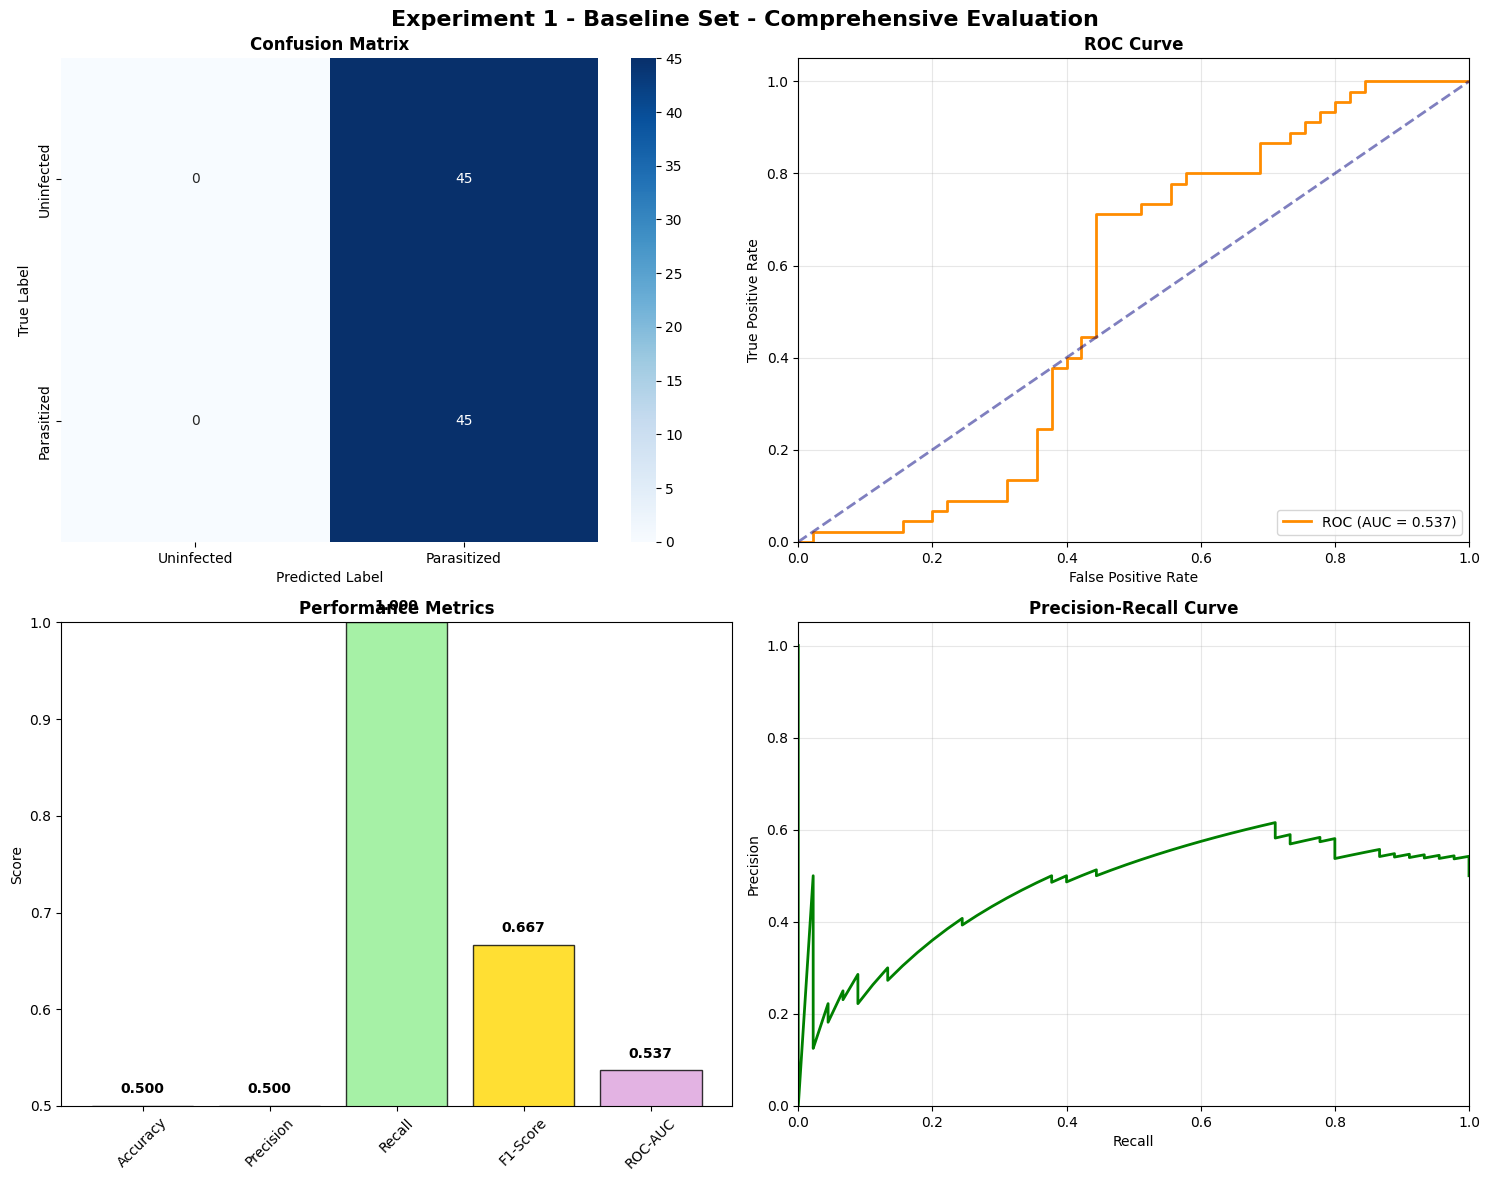

In [83]:
# Dictionary to store results from all experiments
all_experiment_results = {}

# function to build the EfficientNetB0 baseline model
def build_efficientnet_baseline():
    """Build EfficientNetB0 model for baseline experiment"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Build the EfficientNetB0 baseline model
eff_baseline = build_efficientnet_baseline()

#  Experiment 1 Training & Evaluation
print(" Training Experiment 1: EfficientNetB0 Baseline...")

history_baseline = eff_baseline.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Evaluate baseline with comprehensive metrics
print("\n Evaluating Experiment 1...")
results_baseline = comprehensive_evaluation(eff_baseline, test_gen, "Experiment 1 - Baseline")

# Store results
all_experiment_results['1. Baseline'] = results_baseline


 EXPERIMENT 2: EfficientNetB0 with Fine-tuning
Phase 1: Training with frozen base...
Epoch 1/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.5322 - loss: 0.7198 - precision: 0.4696 - recall: 0.3568 - val_accuracy: 0.5000 - val_loss: 0.6960 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5029 - loss: 0.7025 - precision: 0.4839 - recall: 0.3956
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5030 - loss: 0.7030 - precision: 0.4853 - recall: 0.3997 - val_accuracy: 0.5000 - val_loss: 0.6995 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.4857 - loss: 0.7132 - precision: 0.4899 - recall: 0.4425 - val_accuracy: 0.5000 - val_loss: 0.6934 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Restoring model weights 

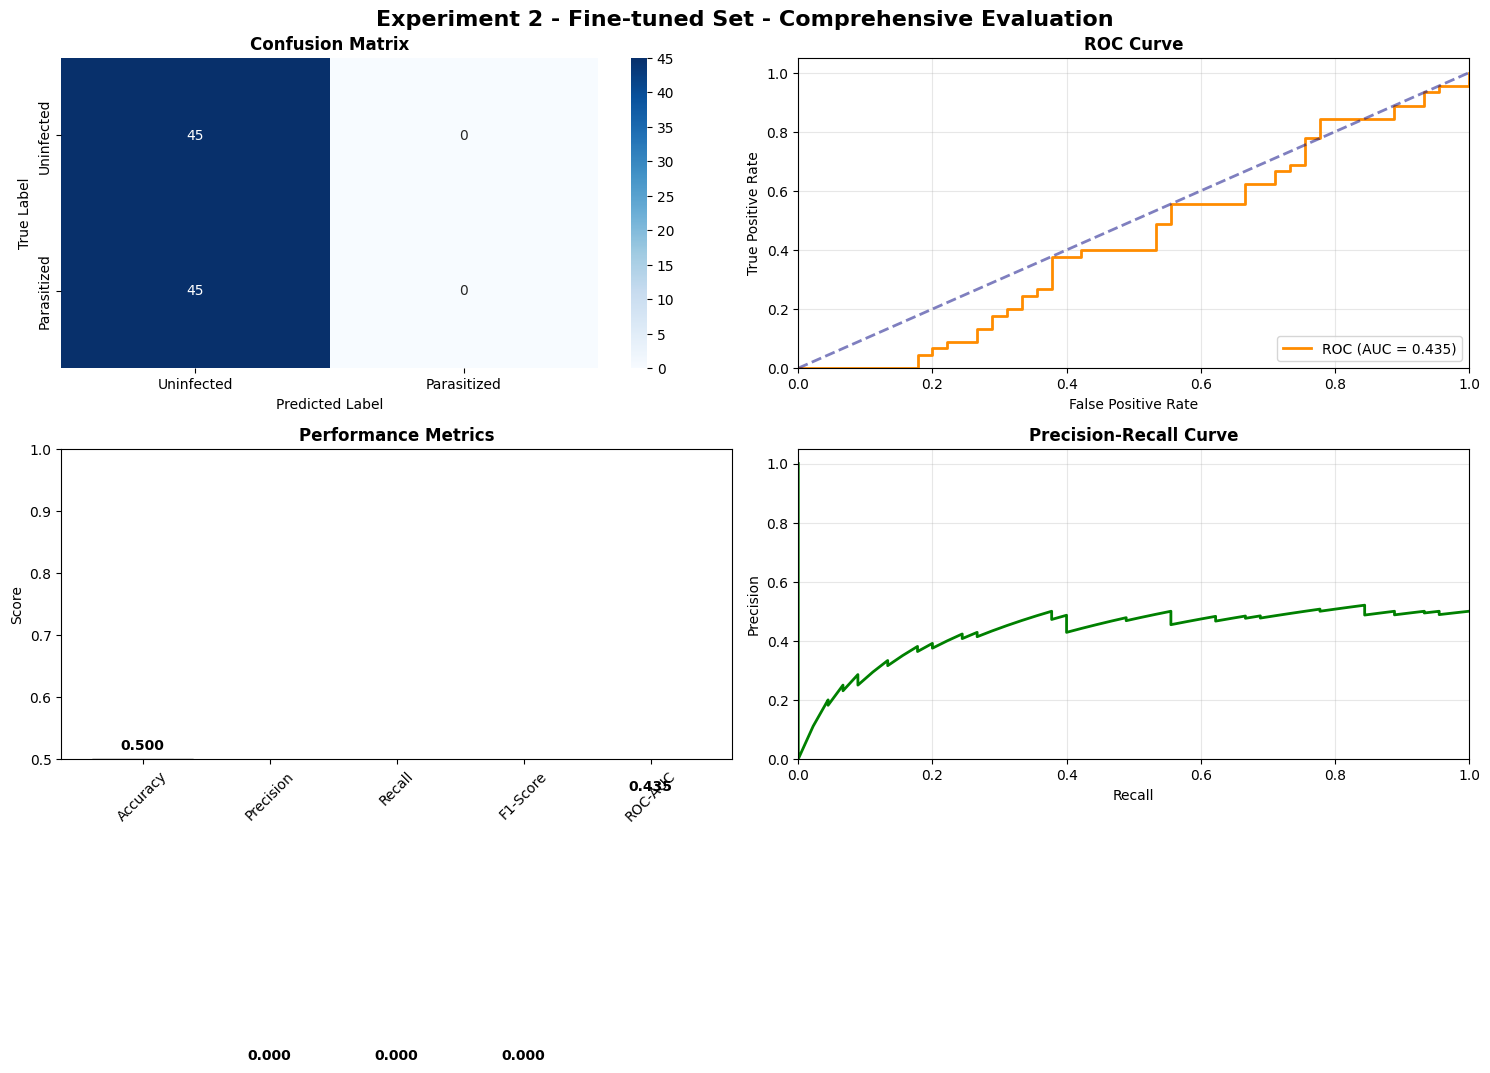

In [77]:
print("\n EXPERIMENT 2: EfficientNetB0 with Fine-tuning")
print("="*50)

def build_efficientnet_finetune():
    """Build EfficientNetB0 model for fine-tuning"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze all layers initially
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    return model, base_model

# Build model for fine-tuning
eff_finetune, eff_ft_base = build_efficientnet_finetune()

# Phase 1: Train with frozen base
print("Phase 1: Training with frozen base...")
eff_finetune.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

history_ft1 = eff_finetune.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\nPhase 2: Fine-tuning last 30 layers...")

# Unfreeze last 30 layers for fine-tuning
eff_ft_base.trainable = True
for layer in eff_ft_base.layers[:-30]:
    layer.trainable = False

print(f"Trainable layers: {sum([layer.trainable for layer in eff_ft_base.layers])}/{len(eff_ft_base.layers)}")

# Recompile with lower learning rate
eff_finetune.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Fine-tune the model
history_ft2 = eff_finetune.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Evaluate fine-tuned model
print("\n Evaluating Experiment 2...")
results_finetune = comprehensive_evaluation(eff_finetune, test_gen, "Experiment 2 - Fine-tuned")

# Store results
all_experiment_results['2. Fine-tuned'] = results_finetune


 EXPERIMENT 3: Simplified EfficientNetB0
 Simplified model built successfully
 Training Experiment 3: Simplified Architecture...
Epoch 1/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.4248 - loss: 0.7586 - precision: 0.4194 - recall: 0.4580 - val_accuracy: 0.5000 - val_loss: 0.6954 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4836 - loss: 0.7030 - precision: 0.3874 - recall: 0.1577 - val_accuracy: 0.5000 - val_loss: 0.6949 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4389 - loss: 0.7102 - precision: 0.4408 - recall: 0.6633
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.4401 - loss: 0.7101 - precision: 0.4429 - recall: 0.6674 - val_accuracy: 0.5000 - val_loss: 0.6959 - val_precision: 0.5000 - val_recall: 1.0000 - learni


 Experiment 3 - Simplified Set - COMPREHENSIVE METRICS:
 Accuracy:    0.5000
 Precision:   0.5000
 Recall:      1.0000
 F1-Score:    0.6667
 ROC-AUC:     0.7205


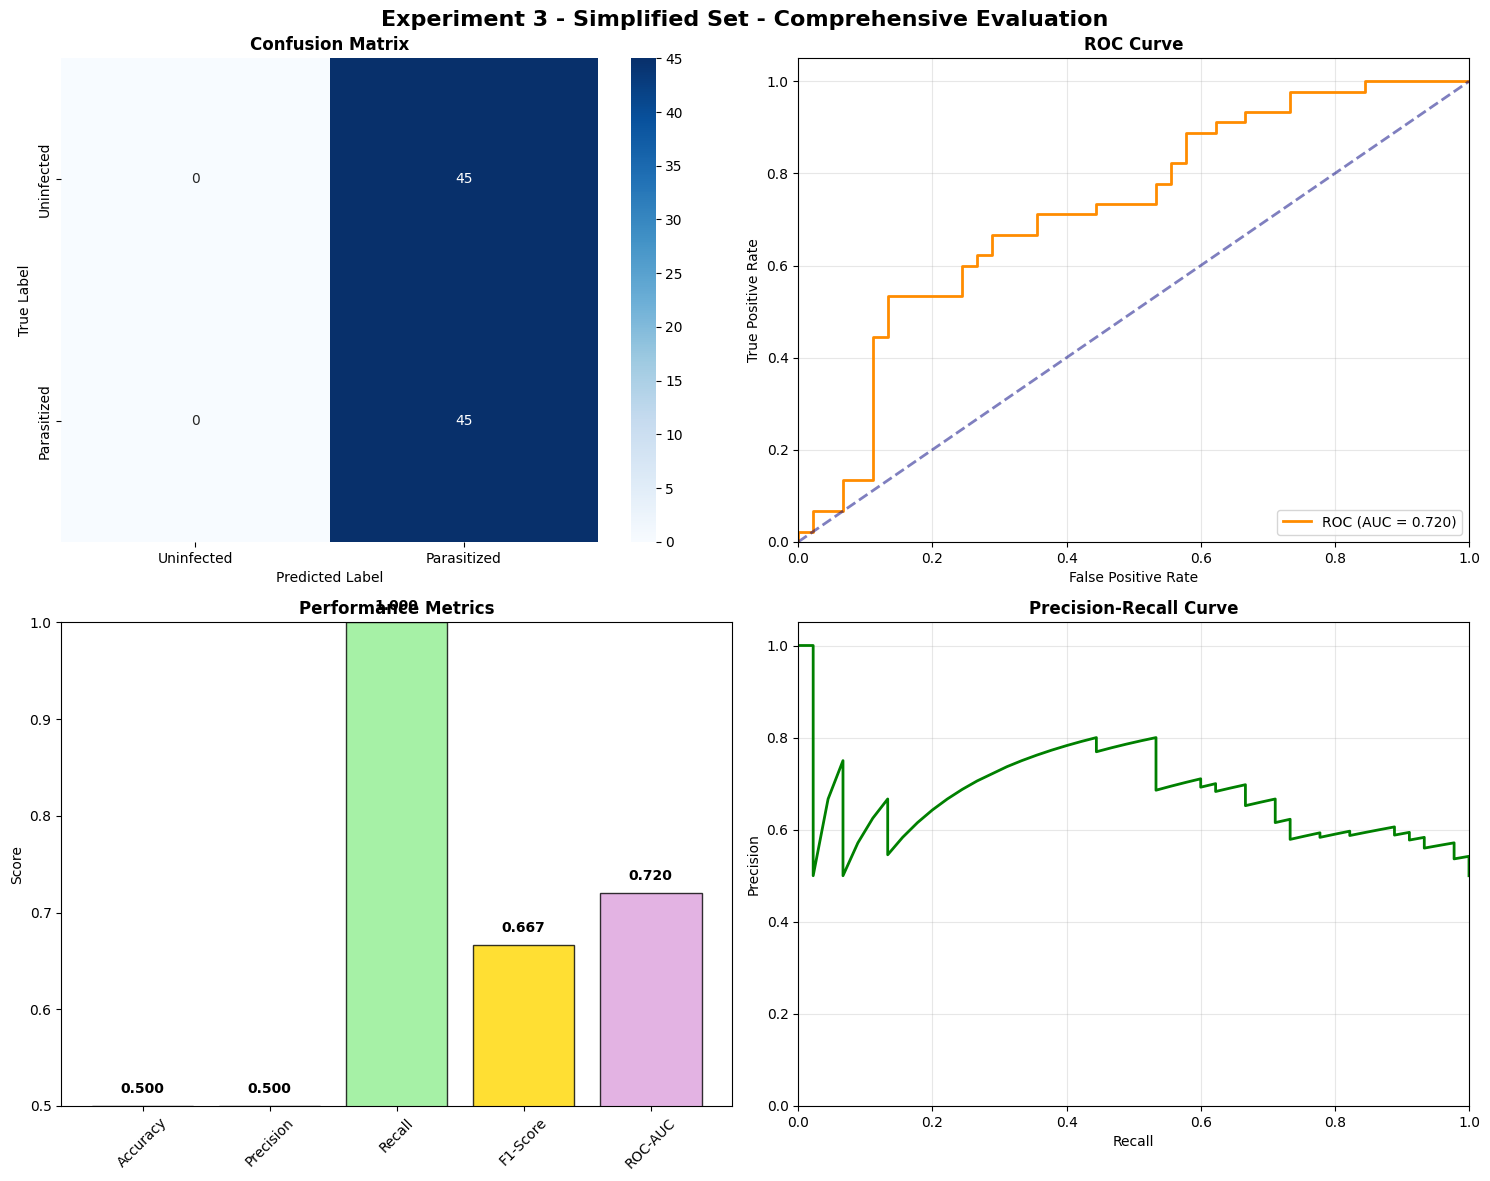

In [84]:
print("\n EXPERIMENT 3: Simplified EfficientNetB0")
print("="*50)

def build_simplified_efficientnet():
    """Build simplified EfficientNetB0 with reduced complexity"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Build and train simplified model
eff_simple = build_simplified_efficientnet()
print(" Simplified model built successfully")

print(" Training Experiment 3: Simplified Architecture...")
history_simple = eff_simple.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Evaluate simplified model
print("\n Evaluating Experiment 3...")
results_simple = comprehensive_evaluation(eff_simple, test_gen, "Experiment 3 - Simplified")

# Store results
all_experiment_results['3. Simplified'] = results_simple


EXPERIMENT 4: EfficientNetB0 with Heavy Augmentation
Found 420 images belonging to 2 classes.
Training Experiment 4: Heavy Augmentation...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5052 - loss: 0.7236 - precision: 0.5013 - recall: 0.4744 - val_accuracy: 0.5000 - val_loss: 0.7341 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4812 - loss: 0.7318 - precision: 0.3581 - recall: 0.1207 - val_accuracy: 0.5000 - val_loss: 0.6939 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5494 - loss: 0.6887 - precision: 0.5450 - recall: 0.6758
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5474 - loss: 0.6891 - precision: 0.5430 - recall: 0.6727 - val_accuracy: 0.5000 - val_loss: 0.6941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5255 - loss: 0.6993 - precision: 0.5581 - r

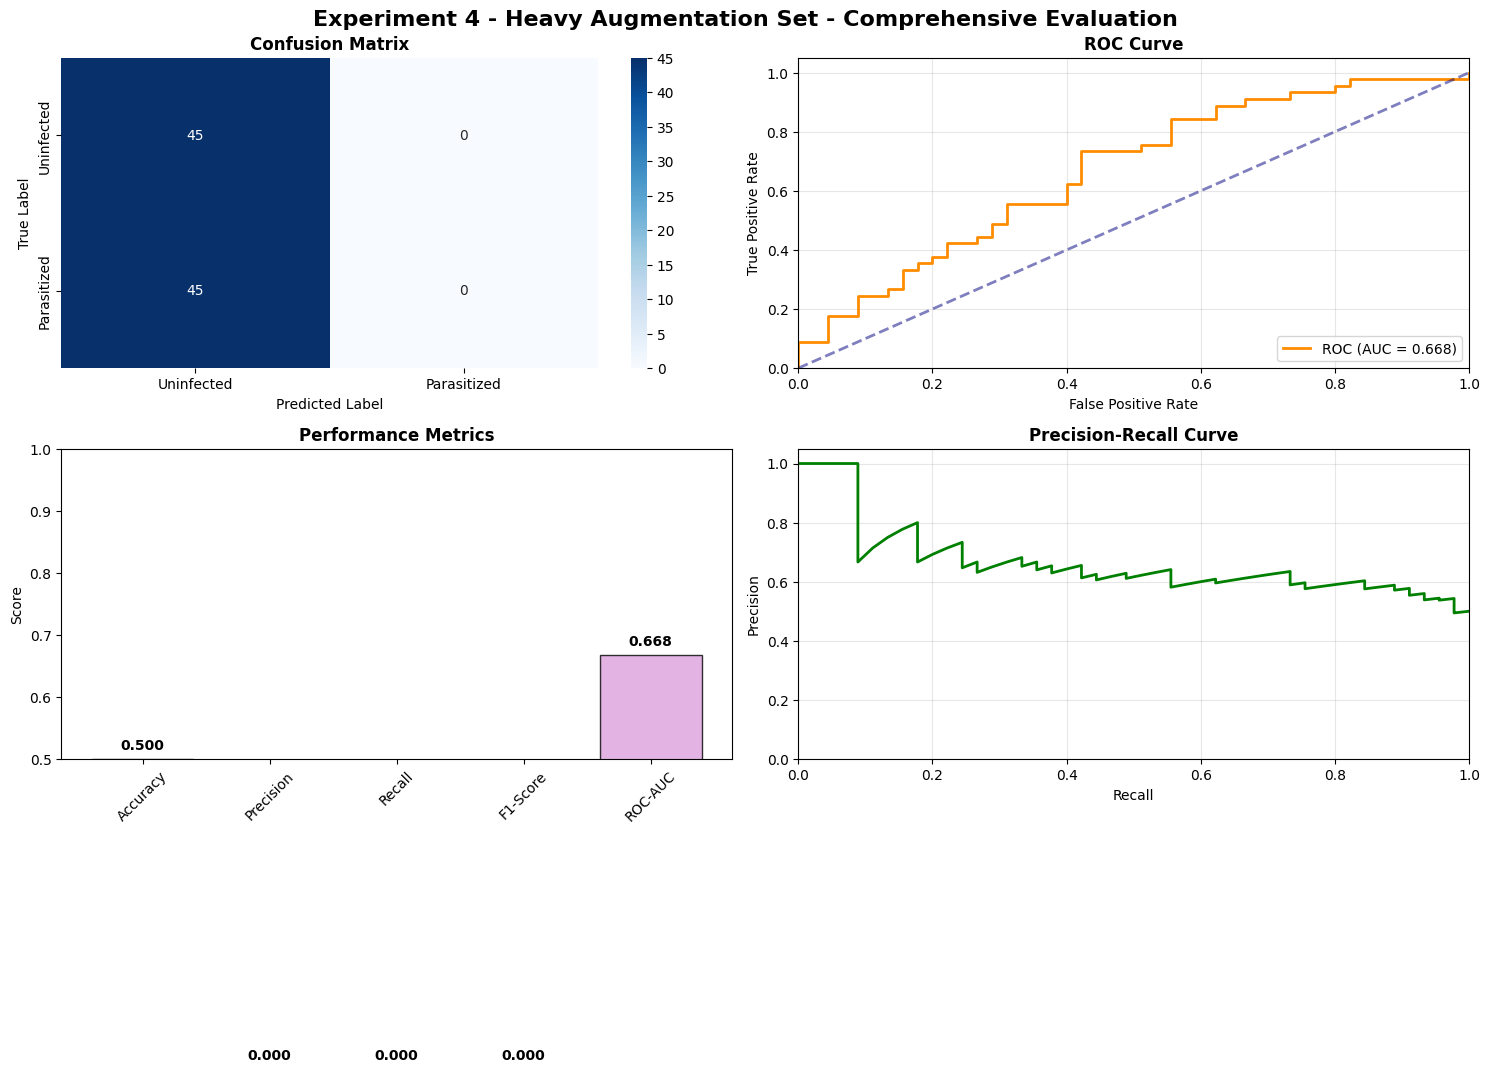

In [86]:
print("\nEXPERIMENT 4: EfficientNetB0 with Heavy Augmentation")
print("="*50)

def create_augmented_generator():
    """Create data generator with heavy augmentation"""
    heavy_augmentation = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.3,
        brightness_range=[0.8, 1.2],
        shear_range=0.2,
        fill_mode='nearest'
    )

    return heavy_augmentation.flow_from_directory(
        split_dirs["train"],
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

# Create augmented generator
augmented_train_gen = create_augmented_generator()

# Build model for augmentation experiment
eff_aug = build_efficientnet_baseline()

print("Training Experiment 4: Heavy Augmentation...")
history_aug = eff_aug.fit(
    augmented_train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Evaluate augmentation model
print("\n Evaluating Experiment 4...")
results_aug = comprehensive_evaluation(eff_aug, test_gen, "Experiment 4 - Heavy Augmentation")

# Store results
all_experiment_results['4. Heavy Aug'] = results_aug


 EXPERIMENT 5: EfficientNetB0 with RMSprop Optimizer
✓ RMSprop model built successfully
 Training Experiment 5: RMSprop Optimizer...
Epoch 1/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5116 - loss: 0.8207 - precision: 0.4893 - recall: 0.4453 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4805 - loss: 0.7128 - precision: 0.4967 - recall: 0.4997
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4800 - loss: 0.7134 - precision: 0.4949 - recall: 0.4930 - val_accuracy: 0.5000 - val_loss: 0.6938 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/4
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4726 - loss: 0.7067 - precision: 0.4584 - recall: 0.4404
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
14/14 ━━━━━━━━━━

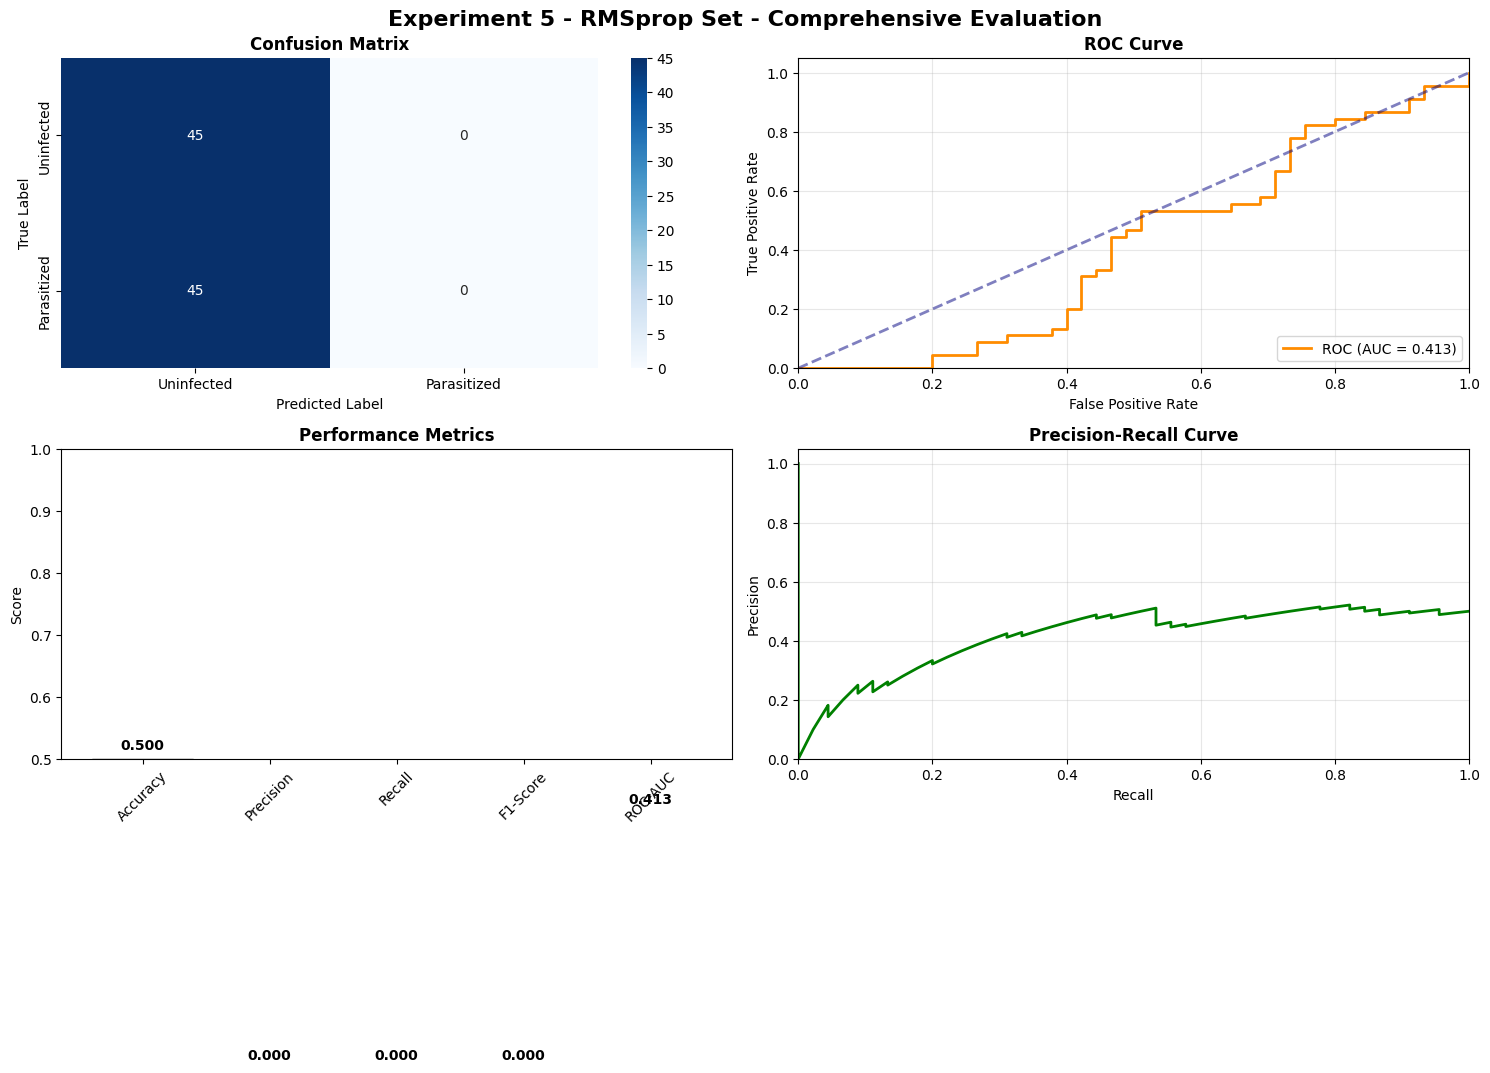

In [87]:
print("\n EXPERIMENT 5: EfficientNetB0 with RMSprop Optimizer")
print("="*50)

def build_rmsprop_model():
    """Build EfficientNetB0 with RMSprop optimizer"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    #  RMSprop instead of Adam
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Build and train RMSprop model
eff_rmsprop = build_rmsprop_model()
print("✓ RMSprop model built successfully")

print(" Training Experiment 5: RMSprop Optimizer...")
history_rmsprop = eff_rmsprop.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Evaluate RMSprop model
print("\n Evaluating Experiment 5...")
results_rmsprop = comprehensive_evaluation(eff_rmsprop, test_gen, "Experiment 5 - RMSprop")

# Store results
all_experiment_results['5. RMSprop'] = results_rmsprop

#  COMPREHENSIVE RESULTS COMPARISON


In [90]:
import pandas as pd

print("\n" + "="*80)
print(" COMPREHENSIVE EXPERIMENTAL RESULTS ")
print("="*80)

# Create detailed comparison table
comparison_data = []
for exp_name, results in all_experiment_results.items():
    comparison_data.append({
        'Experiment': exp_name,
        'Accuracy': f"{results['accuracy']:.4f}",
        'Precision': f"{results['precision']:.4f}",
        'Recall': f"{results['recall']:.4f}",
        'F1-Score': f"{results['f1_score']:.4f}",
        'ROC-AUC': f"{results['roc_auc']:.4f}"
    })

# Convert to DataFrame for nice display
df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))

# Find best experiment for each metric
print("\n BEST PERFORMANCE BY METRIC:")
print("="*50)
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for metric, name in zip(metrics, metric_names):
    best_exp = max(all_experiment_results.items(), key=lambda x: x[1][metric])
    print(f" {name:<12}: {best_exp[0]} - {best_exp[1][metric]:.4f}")

# Find overall best (by F1-Score)
best_overall = max(all_experiment_results.items(), key=lambda x: x[1]['f1_score'])
print("\n" + "="*80)
print(" OVERALL BEST EXPERIMENT (by F1-Score):")
print(f"✓ {best_overall[0]}")
print(f"✓ F1-Score:    {best_overall[1]['f1_score']:.4f}")
print(f"✓ Accuracy:    {best_overall[1]['accuracy']:.4f}")
print(f"✓ Precision:   {best_overall[1]['precision']:.4f}")
print(f"✓ Recall:      {best_overall[1]['recall']:.4f}")
print(f"✓ ROC-AUC:     {best_overall[1]['roc_auc']:.4f}")
print("="*80)


 COMPREHENSIVE EXPERIMENTAL RESULTS 

   Experiment Accuracy Precision Recall F1-Score ROC-AUC
  1. Baseline   0.5000    0.5000 1.0000   0.6667  0.5368
3. Simplified   0.5000    0.5000 1.0000   0.6667  0.7205
 4. Heavy Aug   0.5000    0.0000 0.0000   0.0000  0.6677
   5. RMSprop   0.5000    0.0000 0.0000   0.0000  0.4128

 BEST PERFORMANCE BY METRIC:
 Accuracy    : 1. Baseline - 0.5000
 Precision   : 1. Baseline - 0.5000
 Recall      : 1. Baseline - 1.0000
 F1-Score    : 1. Baseline - 0.6667
 ROC-AUC     : 3. Simplified - 0.7205

 OVERALL BEST EXPERIMENT (by F1-Score):
✓ 1. Baseline
✓ F1-Score:    0.6667
✓ Accuracy:    0.5000
✓ Precision:   0.5000
✓ Recall:      1.0000
✓ ROC-AUC:     0.5368



 COMPREHENSIVE VISUAL COMPARISON...


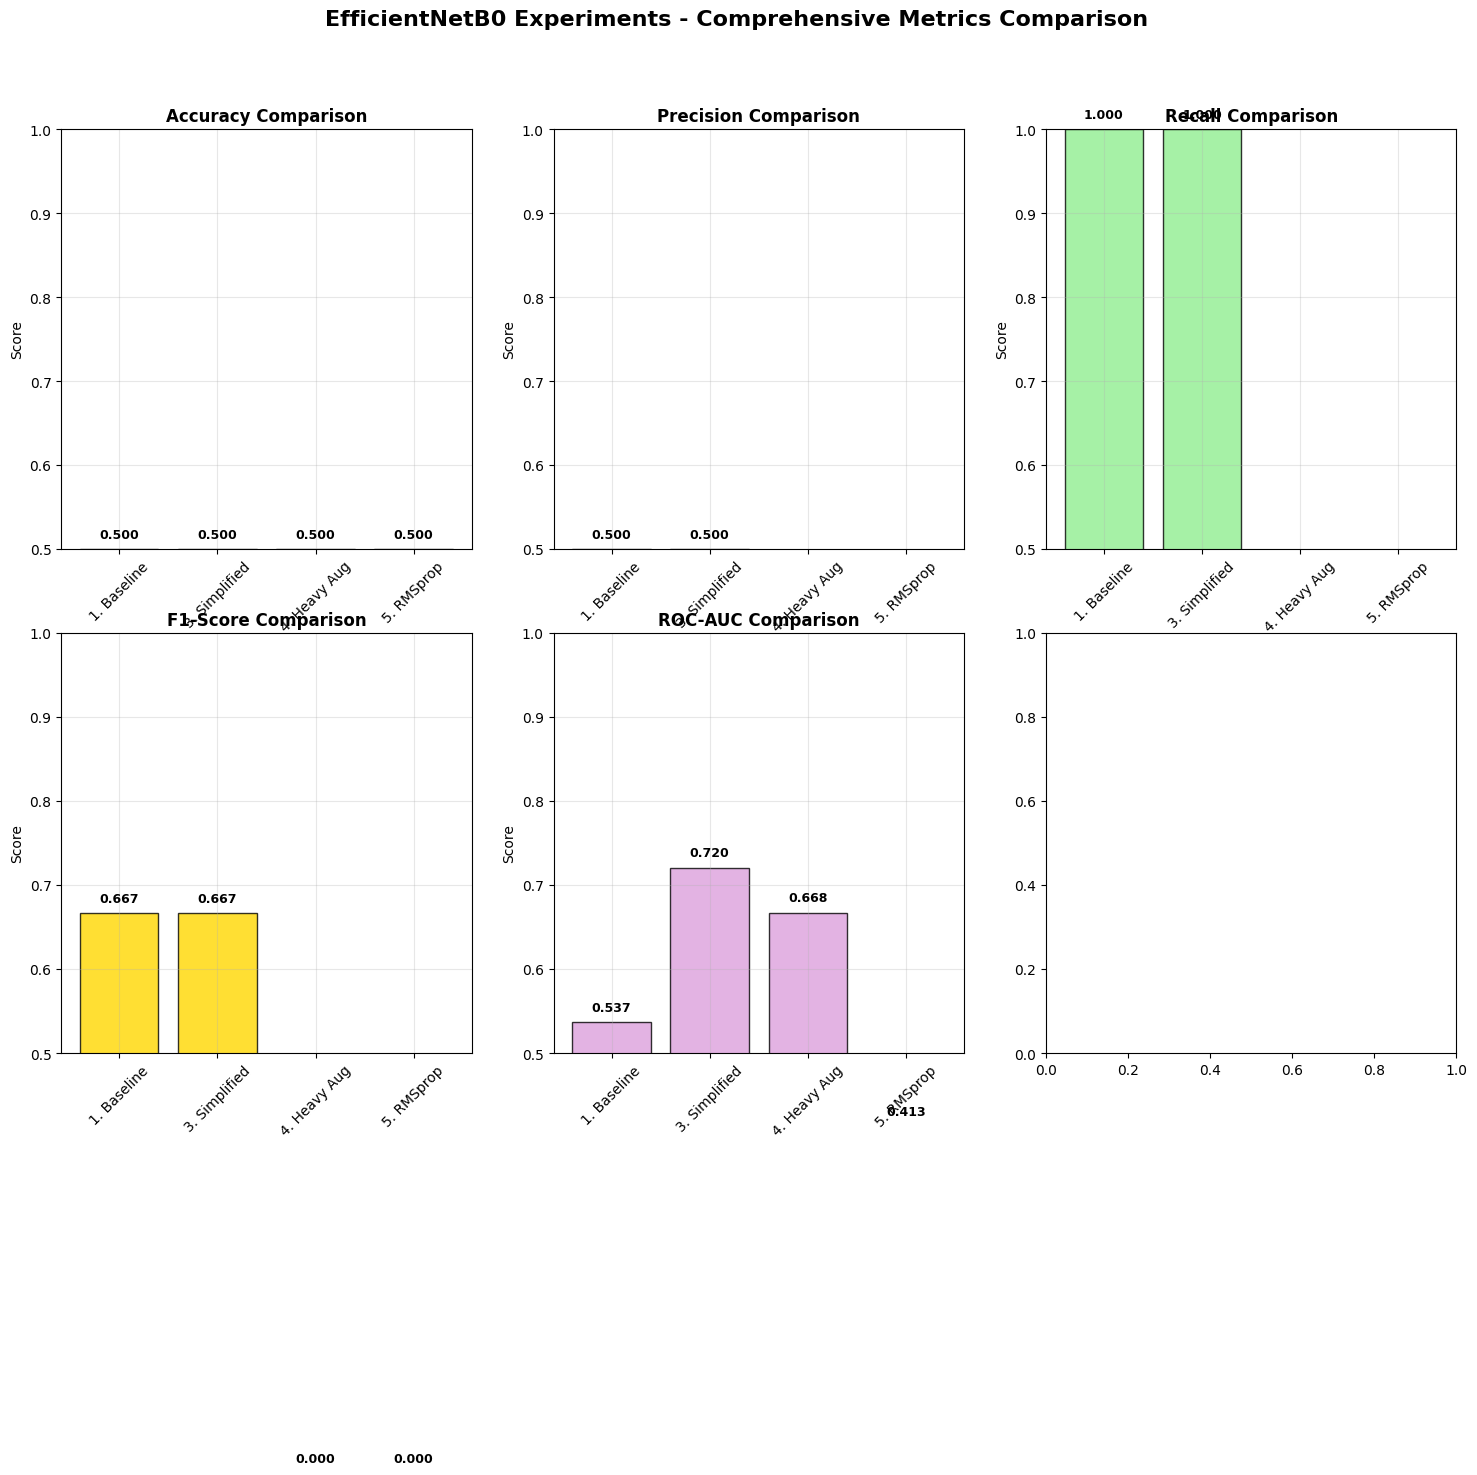

In [91]:
print("\n COMPREHENSIVE VISUAL COMPARISON...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('EfficientNetB0 Experiments - Comprehensive Metrics Comparison',
             fontsize=16, fontweight='bold')

experiments = list(all_experiment_results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']

# metric plots
for i, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
    row, col = i // 3, i % 3
    values = [all_experiment_results[exp][metric] for exp in experiments]

    bars = axes[row, col].bar(experiments, values, color=color, alpha=0.8, edgecolor='black')
    axes[row, col].set_title(f'{name} Comparison', fontweight='bold')
    axes[row, col].set_ylabel('Score')
    axes[row, col].set_ylim(0.5, 1.0)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(True, alpha=0.3)

    # Add value labels
    for bar, value in zip(bars, values):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Radar chart for overall comparison
ax_radar = axes[1, 2]
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()